<a href="https://colab.research.google.com/github/howardcy/LewisUniversity/blob/main/predict_next_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import nltk
from nltk.tokenize import word_tokenize
import pickle
import pprint
import re
import numpy as np

### Prepare Data

# Word Predition using LSTM

In [ ]:
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg
tokens = [word.lower() for word in gutenberg.words('austen-emma.txt') if word.isalpha()]

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [ ]:
tokens[1000:1040]

['her',
 'but',
 'with',
 'compassion',
 'though',
 'it',
 'had',
 'been',
 'entirely',
 'a',
 'match',
 'of',
 'affection',
 'when',
 'he',
 'was',
 'now',
 'obliged',
 'to',
 'part',
 'with',
 'miss',
 'taylor',
 'too',
 'and',
 'from',
 'his',
 'habits',
 'of',
 'gentle',
 'selfishness',
 'and',
 'of',
 'being',
 'never',
 'able',
 'to',
 'suppose',
 'that',
 'other']

### Create sequences

In [ ]:
seq_len = 3  # window size

train_len = seq_len + 1
text_sequences = []
for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)
    
sequences = {}
count = 1
for i in range(len(tokens)):
    if tokens[i] not in sequences:
        sequences[tokens[i]] = count
        count += 1

### Vectorize

Using [tf.keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).  This class allows to vectorize a text corpus, by turning each text into a sequence of integers. 

In [ ]:

print(text_sequences[100:110])
pprint.pprint(sequences['woman'])

[['caresses', 'and', 'her', 'place'], ['and', 'her', 'place', 'had'], ['her', 'place', 'had', 'been'], ['place', 'had', 'been', 'supplied'], ['had', 'been', 'supplied', 'by'], ['been', 'supplied', 'by', 'an'], ['supplied', 'by', 'an', 'excellent'], ['by', 'an', 'excellent', 'woman'], ['an', 'excellent', 'woman', 'as'], ['excellent', 'woman', 'as', 'governess']]
78


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)

pickle.dump(tokenizer, open('emma_tokenizer.pkl', 'wb'))
sequences = tokenizer.texts_to_sequences(text_sequences) 

#Collecting some information   
vocabulary_size = len(tokenizer.word_counts)+1
print("Vocabulary size {}". format(vocabulary_size))

n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

Vocabulary size 7079


In [ ]:
train_inputs = n_sequences[:,:-1]
train_targets = n_sequences[:,-1]
train_targets = to_categorical(train_targets, num_classes=vocabulary_size)
seq_len = train_inputs.shape[1]
train_inputs.shape

(161596, 3)

In [ ]:
train_targets[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

## Create the model

In [ ]:
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential, load_model


#model = load_model("emma_model.h5")

model = Sequential()
model.add(Embedding(vocabulary_size, seq_len, input_length=seq_len))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50,activation='relu'))
model.add(Dense(vocabulary_size, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 3)              21237     
                                                                 
 lstm_2 (LSTM)               (None, 3, 50)             10800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 7079)              361029    
                                                                 
Total params: 415,816
Trainable params: 415,816
Non-trainable params: 0
_________________________________________________________________
None


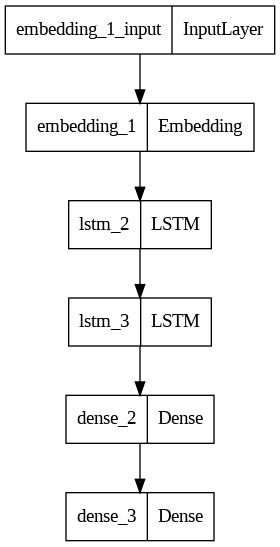

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Compile the model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit the model
To build an accurate model takes many epochs. This will take hours to run.  

In [ ]:
history = model.fit(train_inputs,train_targets,epochs=250,verbose=1)
model.save("emma_model.h5")

Epoch 1/250
5050/5050 [==============================] - 117s 22ms/step - loss: 6.3155 - accuracy: 0.0365
Epoch 2/250
5050/5050 [==============================] - 111s 22ms/step - loss: 5.8783 - accuracy: 0.0663
Epoch 3/250
5050/5050 [==============================] - 113s 22ms/step - loss: 5.5621 - accuracy: 0.0966
Epoch 4/250
5050/5050 [==============================] - 113s 22ms/step - loss: 5.3590 - accuracy: 0.1104
Epoch 5/250
5050/5050 [==============================] - 112s 22ms/step - loss: 5.2201 - accuracy: 0.1180
Epoch 6/250
5050/5050 [==============================] - 112s 22ms/step - loss: 5.1137 - accuracy: 0.1242
Epoch 7/250
5050/5050 [==============================] - 111s 22ms/step - loss: 5.0280 - accuracy: 0.1286
Epoch 8/250
5050/5050 [==============================] - 115s 23ms/step - loss: 4.9582 - accuracy: 0.1323
Epoch 9/250
5050/5050 [==============================] - 112s 22ms/step - loss: 4.9012 - accuracy: 0.1347
Epoch 10/250
5050/5050 [======================

### Visualize the model improvement

In [ ]:
history_dict = history.history
loss = history_dict['loss']
accuracy = history_dict['accuracy']
epochs = range(1, len(loss) + 1)

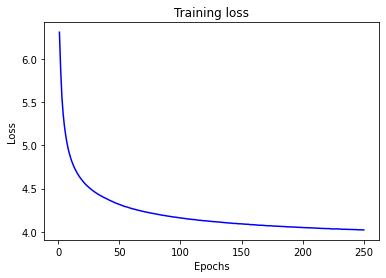

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

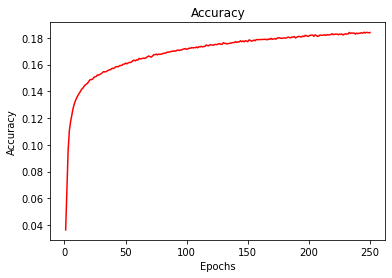

In [ ]:
plt.plot(epochs, accuracy, 'r', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Predict Words

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle

model = load_model('emma_model.h5')
tokenizer = pickle.load(open('emma_tokenizer.pkl', 'rb'))

input_text=""
while True:
    input_text = input().strip().lower()
    if input_text == "stop!!":
        break
    encoded_text = tokenizer.texts_to_sequences([input_text])[0]
    pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
    print(encoded_text, pad_encoded)
    for i in (model.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
      pred_word = tokenizer.index_word[i]
      print("Next word suggestion:",pred_word)

this is a
[53, 22, 6] [[53 22  6]]
1/1 [==============================] - 2s 2s/step
Next word suggestion: very
Next word suggestion: little
Next word suggestion: great
he saw a
[16, 196, 6] [[ 16 196   6]]
1/1 [==============================] - 0s 50ms/step
Next word suggestion: very
Next word suggestion: great
Next word suggestion: few
the man was
[2, 109, 9] [[  2 109   9]]
1/1 [==============================] - 0s 36ms/step
Next word suggestion: not
Next word suggestion: to
Next word suggestion: very


KeyboardInterrupt: ignored

## Reference
[Exploring the Next Word Predictor!](https://towardsdatascience.com/exploring-the-next-word-predictor-5e22aeb85d8f)